In [1]:
#Imports
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import pandas as pd
from numpy.random import randn
import re
from PyEMD import EMD
import catch22
import seaborn as sns
from datetime import datetime
from io import StringIO
import scipy
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
#from scipy import scipy.signal
import pickle
from scipy.stats import norm
import matplotlib.mlab as mlab
from IPython.display import Image  
#from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
import nolds
from scipy.stats import entropy
from math import log, e
from scipy.signal import hilbert, chirp
import timeit
from scipy import signal
from PyEMD import EMD
import numpy  as np
#import pylab as plt
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from detecta import detect_peaks
from scipy.signal import welch
from scipy.fftpack import fft
from sklearn.metrics import precision_score
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import wfdb

from collections import defaultdict, Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from simpledbf import Dbf5
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


import shap

import random

from sklearn.model_selection import RandomizedSearchCV

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


## Define functions to extract features

In [9]:
import catch22_C

def catch22_all(data):

	features = [
	'DN_HistogramMode_5',
	'DN_HistogramMode_10',
	'CO_f1ecac',
	'CO_FirstMin_ac',
	'CO_HistogramAMI_even_2_5',
	'CO_trev_1_num',
	'MD_hrv_classic_pnn40',
	'SB_BinaryStats_mean_longstretch1',
	'SB_TransitionMatrix_3ac_sumdiagcov',
	'PD_PeriodicityWang_th0_01',
	'CO_Embed2_Dist_tau_d_expfit_meandiff',
	'IN_AutoMutualInfoStats_40_gaussian_fmmi',
	'FC_LocalSimple_mean1_tauresrat',
	'DN_OutlierInclude_p_001_mdrmd',
	'DN_OutlierInclude_n_001_mdrmd',
	'SP_Summaries_welch_rect_area_5_1',
	'SB_BinaryStats_diff_longstretch0',
	'SB_MotifThree_quantile_hh',
	'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
	'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
	'SP_Summaries_welch_rect_centroid',
	'FC_LocalSimple_mean3_stderr'
	]	

	data = list(data)

	featureOut = []
	for f in features:
		featureFun = getattr(catch22_C, f)
		featureOut.append(featureFun(data))

	return {'names': features, 'values': featureOut}

In [10]:
def unpack_comments(comments):
    '''
    function to unpack comments and convert them to features
    '''
    features = []
    features.append(int(comments[1].split(" ")[1]))
    features.append(float(comments[2].split(" ")[1]))
    features.append(float(comments[3].split(" ")[1]))
    features.append((comments[4].split(" ")[1]))
    features.append((comments[5].split(" ")[1]))
    features.append((comments[6].split(" ")[1]))
    features.append((comments[7].split(" ")[1]))
    features.append(comments[8].split(" ")[1])
    features.append(comments[9].split(" ")[1])
    features.append(comments[10].split(" ")[1])
    features.append(comments[11].split(" ")[1])
    features.append(comments[12].split(" ")[1])
    features.append(comments[13].split(" ")[1])
    features.append(comments[14].split(" ")[1])
    return features
    #filename = filename.split(".")[0]

In [11]:
def entropy2(labels, base=None):
    '''
    A function to extract entropy from a time series, 
    ref: https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
    '''
    n_labels = len(labels)
    if n_labels <= 1:
        return 0
    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)
    if n_classes <= 1:
        return 0
    ent = 0.
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)
        
    return ent

In [12]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values



def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values



def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
            print(type(features))
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)


## Read in signals to a dataframe

In [34]:
#Put all timeseries as rows in a data frame with the final column the target label

#make dataframe to fill
#df1 = pd.DataFrame(randn(24000,301))
#df2 = pd.DataFrame(randn(24000,301))
#df = pd.DataFrame(columns='RecID Gestation Rectime Age Parity Abortions Weight Hypertension Diabetes Ppos Bleed1T Bleed2T Funneling Smoker'.split())
#df2 = pd.DataFrame(columns='c1 c2 c3 OutlierInt c5 1_e_AC ACmin1A c8 FPS_centroid c10 TRS c12 AMImin1 Sdiff1 Sdiff2 IncEntropy deltaCorr c18 PropFluc1 PropFluc2 c21 WPeriodicity'.split())
#df3 = pd.DataFrame(columns='mu signma'.split())
#df4 = pd.DataFrame(columns='mf_ts sh_ts e1_ts e2_ts mf sh e1 e2 f0 a0 f1 a1 f2 a2'.split())
#df6 = pd.DataFrame(columns='RecID Gestation Rectime mu sigma medfreq Entropy 0 1 2 3 4 5 6 FT3f 8 9 10 11 12 13 14 15 16 17 18 19 PSD5A 21 22 23 AC4f AC5f 26 AC2A 28 29 AC5A 31'.split())
dfi = pd.DataFrame()
directory_path = '/Users/madeleineanthonisen/Documents/Random/wfdb-python/term-preterm-ehg-database-1.0.1/tpehgdb/'
#directory = os.fsencode(directory_in_str)

#some attributes for signal
fs = 20
f_s = 20
dt = 1/f_s
t_n = 1200
sample_rate = 1 / f_s
denominator = 10
list_of_features = []
percentile = 10


#Loop to apply preprocessing to all files in directory
i=0
for file in os.listdir(directory_path):
    filename = os.fsdecode(file)
    #if filename.endswith(".dat") or filename.endswith(".hea"):
    if filename.endswith(".dat"):
        i+=1
        
        filename = filename.split(".")[0]
        #print(filename)
        signals, fields = wfdb.rdsamp('/Users/madeleineanthonisen/Documents/Random/wfdb-python/term-preterm-ehg-database-1.0.1/tpehgdb/'+filename, channels=[9])
        
        #cut for noise at start&end of recording
        ts = []
        signals = signals[6000:30000]
        comments = fields['comments']
        feats = unpack_comments(comments)
        if feats[1]<37:
            label = 1
        else:
            label = 0
        
        #print(label)
        #print(type(label))
            
        #signals = signals.reshape(1,len(signals))
        ts = np.append(signals,[feats[2],label])
        #ts = np.append(ts,feats[3])
        #ts = np.append(ts,label)
        #ts = ts.reshape(1,len(ts))
        
        #ts = [signals,label]
        #ts = np.array(ts)
        #print(signals.shape)
        #signals += [label]
        #print(ts.shape)
        #print(type(ts))
        
        s = pd.Series(ts)
        dfi = dfi.append(s, ignore_index=True)
        #print(i)
        #print(feats[0])

        
    else:
         continue
#print(features)
#print(i)
#print(len(signals))
#print(signals.shape)

In [35]:
dfi.head()

,0,1,2,3,4,5,6,7,8,9,...,23992,23993,23994,23995,23996,23997,23998,23999,24000,24001
0,0.003204,0.001755,-0.000076,-0.001221,-0.001068,-0.000305,0.000229,0.000458,0.000763,0.001755,...,0.003281,0.004654,0.004807,0.002976,0.000229,-0.001068,-0.000153,0.001678,24.4,1.0
1,0.008011,0.005646,0.000534,-0.003815,-0.006180,-0.007324,-0.008392,-0.009384,-0.009766,-0.009003,...,0.001068,0.000229,-0.000916,-0.001221,-0.000076,0.000992,0.000763,-0.000229,22.1,0.0
2,-0.000763,-0.000534,0.001602,0.004044,0.005264,0.005188,0.005035,0.005417,0.005722,0.004883,...,-0.005188,-0.004501,-0.003128,-0.002365,-0.002441,-0.002823,-0.002976,-0.003510,31.0,0.0
3,0.020600,0.023499,0.023117,0.020371,0.019455,0.023041,0.029297,0.035325,0.039673,0.042191,...,-0.003281,-0.000229,0.002136,0.001068,-0.001907,-0.002823,0.000000,0.004196,22.0,0.0
4,-0.005035,-0.004349,-0.003662,-0.003357,-0.003662,-0.004120,-0.004273,-0.003586,-0.002670,-0.002518,...,-0.001984,-0.001602,-0.001678,-0.002365,-0.003204,-0.003586,-0.003586,-0.003510,31.3,0.0


In [15]:
dfi = dfi.drop(24000,axis=1)

In [12]:
# M = dfi.values
# X = M[:, :-1]
# y = M[:, -1].astype(float)

In [30]:
dfi[24001].value_counts()

0.0    261
1.0     38
Name: 24001, dtype: int64

## Train-test split & SMOTE of training set

In [75]:
#Train-test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,f1_score,accuracy_score

X = dfi.drop([24001],axis=1)
y = dfi[24001]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

sm = SMOTE(random_state=2)


X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())


In [17]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


After OverSampling, counts of label '1': 223
After OverSampling, counts of label '0': 223


In [38]:
dft = X_test.merge(y_test, how='outer', left_index=True, right_index=True)
dft.head()

,0,1,2,3,4,5,6,7,8,9,...,23992,23993,23994,23995,23996,23997,23998,23999,24000,24001
206,-0.001755,-0.002441,-0.002518,-0.001297,0.000916,0.002594,0.002213,0.000687,0.000000,0.001297,...,0.000381,0.000610,0.002518,0.003738,0.002441,-0.000305,-0.002365,-0.003128,24.4,0.0
188,0.001984,0.002518,0.003891,0.004120,0.002213,-0.000153,-0.001144,0.000000,0.001831,0.003128,...,-0.003967,-0.005188,-0.006332,-0.006104,-0.004578,-0.002976,-0.003052,-0.004578,31.7,0.0
12,0.003204,0.003433,0.003510,0.002441,0.001144,0.000687,0.000992,0.001526,0.001984,0.002594,...,0.005722,0.005188,0.005264,0.006409,0.007553,0.007553,0.006485,0.005722,32.0,0.0
219,-0.000992,-0.002365,-0.003128,-0.002670,-0.002213,-0.003510,-0.006790,-0.009537,-0.009308,-0.007019,...,0.019379,0.020752,0.021592,0.021439,0.021057,0.021897,0.023957,0.025330,22.1,0.0
237,-0.012741,-0.011673,-0.010758,-0.012970,-0.017624,-0.020829,-0.020066,-0.016480,-0.013352,-0.012055,...,0.011749,0.011215,0.010986,0.009689,0.007477,0.006638,0.008469,0.010681,23.4,0.0


In [11]:
#sns.set_style('whitegrid')
#cmap = sns.cubehelix_palette(light=1, as_cmap=True)
#sns.countplot(x=24001,data=dfi,palette="PuBu")

In [16]:
#sns.set_style('whitegrid')
#dall = pd.concat([df_test,df_train])
#dall.head()
#sns.countplot(x='label',data=df_train,palette="PuBu")


Put the training data in a format to be fed to feature extraction code block; then the test data

In [76]:
df_train = X_train_res
df_train['label'] = y_train_res
df_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,23992,23993,23994,23995,23996,23997,23998,23999,24000,label
0,0.005417,0.007095,0.006485,0.004730,0.003738,0.003891,0.003967,0.003052,0.001984,0.001907,...,-0.002213,-0.000534,0.000534,0.000076,-0.001678,-0.003510,-0.003967,-0.003204,21.7,0.0
1,-0.009384,-0.003738,0.000687,0.001526,0.001068,0.002518,0.005341,0.005646,0.001221,-0.005951,...,-0.048295,-0.046006,-0.044480,-0.046006,-0.048295,-0.048066,-0.044556,-0.040208,22.9,0.0


In [77]:
df_test = X_test
dtemp = pd.DataFrame(y_test)
df_test['label'] = dtemp.loc[:]
#df_test['label'] = dtemp.loc[:,(24000)]
df_test.head(2)
#dtemp.head()
# df_test = X_test_res
# df_test['label'] = y_test_res
# df_test.head(2)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,0,1,2,3,4,5,6,7,8,9,...,23992,23993,23994,23995,23996,23997,23998,23999,24000,label
206,-0.001755,-0.002441,-0.002518,-0.001297,0.000916,0.002594,0.002213,0.000687,0.000000,0.001297,...,0.000381,0.000610,0.002518,0.003738,0.002441,-0.000305,-0.002365,-0.003128,24.4,0.0
188,0.001984,0.002518,0.003891,0.004120,0.002213,-0.000153,-0.001144,0.000000,0.001831,0.003128,...,-0.003967,-0.005188,-0.006332,-0.006104,-0.004578,-0.002976,-0.003052,-0.004578,31.7,0.0


## Extract features from training set

In [78]:
fs = 20
f_s = 20
dt = 1/f_s
t_n = 1200
sample_rate = 1 / f_s
denominator = 10
list_of_features = []
percentile = 10

df_c = pd.DataFrame(columns='c1 c2 c3 OutlierInt c5 1_over_e_Crossing 1st_Min_AC c8 FPS_centroid c10 TRS c12 AMImin1 Sdiff1 Sdiff2 PermutationEntropy CorrelationLengthChange c18 PropFluc1 PropFluc2 c21 Periodicity'.split())
df_p = pd.DataFrame(columns='Rectime label mu sigma medfreq Entropy 0 1 2 3 4 5 6 FT3f 8 9 10 11 12 13 14 15 16 17 18 19 PSD5A 21 22 23 AC4f AC5f 26 AC2A 28 29 Amplitude5thPeak 31'.split())

#for index, row in df_train.iterrows():
for index, row in df_train.iterrows():
    
    #print(catch22_all(row)['values'])
    signals = row.drop([24000,'label'])
    #print(row['label'])
    for z in range(0,20):
        features = []
        sig = signals[1200*z:(1200*z+1200)]
        
        #use catch22 to get features
        #channel 9
        s_c = pd.Series(catch22_all(sig)['values'],index=df_c.columns)            
        df_c = df_c.append(s_c, ignore_index=True)
        
        #entropy
        entropy = entropy2(sig,base=None)
        #entropy = entropy2(imf0, base=None)
        (mu, sigma) = norm.fit(sig)
        N = len(sig)
        T = t_n / N

        f_values, fft_values = get_fft_values(sig.to_numpy(), T, N, f_s)
        f_valuesp, psd_values = get_psd_values(sig, T, N, f_s)
        t_values, autocorr_values = get_autocorr_values(sig, T, N, f_s)
            
        k=0
        power2=0
        while power2 < np.cumsum(psd_values)[-1]/2:
            k+=1
            power2 = np.cumsum(psd_values)[k]
        medfreq2 = f_valuesp[k]


        signal_min = np.nanpercentile(fft_values, percentile)
        signal_max = np.nanpercentile(fft_values, 100-percentile)
        mph = signal_min + (signal_max - signal_min)/denominator

        signal_min1 = np.nanpercentile(psd_values, percentile)
        signal_max1 = np.nanpercentile(psd_values, 100-percentile)
        mph1 = signal_min1 + (signal_max1 - signal_min1)/denominator

        signal_min2 = np.nanpercentile(autocorr_values, percentile)
        signal_max2 = np.nanpercentile(autocorr_values, 100-percentile)
        mph2 = signal_min2 + (signal_max2 - signal_min2)/denominator

        features += [row[24000],row['label']] #row[24000]
        features += [mu,sigma,medfreq2,entropy]
        features += get_features(f_values, fft_values, mph)
        features += get_features(f_valuesp, psd_values, mph1)
        features += get_features(t_values, autocorr_values, mph2) 
        features += [np.sum(f_values*fft_values)/np.sum(f_values)]
        features += [np.sum(np.abs(f_values) ** 2) / N]

        s_p = pd.Series(np.array(features),index=df_p.columns)
        df_p = df_p.append(s_p, ignore_index=True)
        #list_of_features.append(features)
        #feat_array = np.array(list_of_features)

In [79]:
d_train = df_p.merge(df_c, how='outer', left_index=True, right_index=True)

## Extract features from test set

In [80]:
fs = 20
f_s = 20
dt = 1/f_s
t_n = 1200
sample_rate = 1 / f_s
denominator = 10
list_of_features = []
percentile = 10

df_c2 = pd.DataFrame(columns='c1 c2 c3 OutlierInt c5 1_over_e_Crossing 1st_Min_AC c8 FPS_centroid c10 TRS c12 AMImin1 Sdiff1 Sdiff2 PermutationEntropy CorrelationLengthChange c18 PropFluc1 PropFluc2 c21 Periodicity'.split())
df_p2 = pd.DataFrame(columns='Rectime label mu sigma medfreq Entropy 0 1 2 3 4 5 6 FT3f 8 9 10 11 12 13 14 15 16 17 18 19 PSD5A 21 22 23 AC4f AC5f 26 AC2A 28 29 Amplitude5thPeak 31'.split())

for index, row in df_test.iterrows():
    
    #print(catch22_all(row)['values'])
    signals = row.drop([24000,'label'])
    #print(row['label'])
    for z in range(0,20):
        features = []
        sig = signals[1200*z:(1200*z+1200)]
        
        #use catch22 to get features
        #channel 9
        s_c2 = pd.Series(catch22_all(sig)['values'],index=df_c2.columns)            
        df_c2 = df_c2.append(s_c2, ignore_index=True)
        
        #entropy
        entropy = entropy2(sig,base=None)
        #entropy = entropy2(imf0, base=None)
        (mu, sigma) = norm.fit(sig)
        N = len(sig)
        T = t_n / N

        f_values, fft_values = get_fft_values(sig.to_numpy(), T, N, f_s)
        f_valuesp, psd_values = get_psd_values(sig, T, N, f_s)
        t_values, autocorr_values = get_autocorr_values(sig, T, N, f_s)
            
        k=0
        power2=0
        while power2 < np.cumsum(psd_values)[-1]/2:
            k+=1
            power2 = np.cumsum(psd_values)[k]
        medfreq2 = f_valuesp[k]


        signal_min = np.nanpercentile(fft_values, percentile)
        signal_max = np.nanpercentile(fft_values, 100-percentile)
        mph = signal_min + (signal_max - signal_min)/denominator

        signal_min1 = np.nanpercentile(psd_values, percentile)
        signal_max1 = np.nanpercentile(psd_values, 100-percentile)
        mph1 = signal_min1 + (signal_max1 - signal_min1)/denominator

        signal_min2 = np.nanpercentile(autocorr_values, percentile)
        signal_max2 = np.nanpercentile(autocorr_values, 100-percentile)
        mph2 = signal_min2 + (signal_max2 - signal_min2)/denominator

        features += [row[24000],row['label']]
        features += [mu,sigma,medfreq2,entropy]
        features += get_features(f_values, fft_values, mph)
        features += get_features(f_valuesp, psd_values, mph1)
        features += get_features(t_values, autocorr_values, mph2) 
        features += [np.sum(f_values*fft_values)/np.sum(f_values)]
        features += [np.sum(np.abs(f_values) ** 2) / N]

        s_p2 = pd.Series(np.array(features),index=df_p2.columns)
        df_p2 = df_p2.append(s_p2, ignore_index=True)
        #list_of_features.append(features)
        #feat_array = np.array(list_of_features)

In [81]:
d_test = df_p2.merge(df_c2, how='outer', left_index=True, right_index=True)

## Classifiers

In [82]:
X_train = d_train.drop(['label'],axis=1)
#X_train = d_train[['Entropy','Rectime','CorrelationLengthChange','PermutationEntropy','sigma','Periodicity','15','17',\
#  'Amplitude5thPeak','c18','1st_Min_AC','c5','18','PSD5A','c10','21','26','AC5f','OutlierInt','29'
# ]]
#X_train = d_train[['sigma','mu','OutlierInt', 'c5', '1_over_e_Crossing', '1st_Min_AC', 'c8', 'FPS_centroid','c10', 'TRS', 'c12', 'AMImin1', 'Sdiff1', 'Sdiff2', 'PermutationEntropy','CorrelationLengthChange', 'c18', 'PropFluc1', 'PropFluc2', 'c21', 'Periodicity','Entropy','FT3f','PSD5A','AC4f', 'AC5f',  'AC2A', 'Amplitude5thPeak','16','29']]
# X_train = d_train[['mu', 'sigma','Entropy',
#        '5', '6', 'FT3f', '8', '9', '13', '14', '15', '16',
#        '17', '18', '19', 'PSD5A', '21', '22', '23', 'AC4f', 'AC5f', '26',
#        'AC2A', '28', '29', 'Amplitude5thPeak', 'c1', 'c2', 'c3',
#        'OutlierInt', 'c5', '1_over_e_Crossing', '1st_Min_AC', 'c8',
#        'FPS_centroid', 'c10', 'TRS', 'c12', 'AMImin1', 'Sdiff1', 'Sdiff2',
#        'PermutationEntropy', 'CorrelationLengthChange', 'c18', 'PropFluc1',
#        'PropFluc2','Periodicity']]
y_train = d_train['label']

X_test = d_test.drop(['label'],axis=1)
# X_test = d_test[['Entropy','Rectime','CorrelationLengthChange','PermutationEntropy','sigma','Periodicity','15','17',\
#   'Amplitude5thPeak','c18','1st_Min_AC','c5','18','PSD5A','c10','21','26','AC5f','OutlierInt','29'
#  ]]
#X_test = d_test[['sigma','mu','OutlierInt', 'c5', '1_over_e_Crossing', '1st_Min_AC', 'c8', 'FPS_centroid','c10', 'TRS', 'c12', 'AMImin1', 'Sdiff1', 'Sdiff2', 'PermutationEntropy','CorrelationLengthChange', 'c18', 'PropFluc1', 'PropFluc2', 'c21', 'Periodicity','Entropy','FT3f','PSD5A','AC4f', 'AC5f',  'AC2A', 'Amplitude5thPeak','16','29']]
# X_test = d_test[['mu', 'sigma','Entropy',
#        '5', '6', 'FT3f', '8', '9', '13', '14', '15', '16',
#        '17', '18', '19', 'PSD5A', '21', '22', '23', 'AC4f', 'AC5f', '26',
#        'AC2A', '28', '29', 'Amplitude5thPeak', 'c1', 'c2', 'c3',
#        'OutlierInt', 'c5', '1_over_e_Crossing', '1st_Min_AC', 'c8',
#        'FPS_centroid', 'c10', 'TRS', 'c12', 'AMImin1', 'Sdiff1', 'Sdiff2',
#        'PermutationEntropy', 'CorrelationLengthChange', 'c18', 'PropFluc1',
#        'PropFluc2','Periodicity']]
y_test = d_test['label']

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,classification_report,f1_score,accuracy_score

## XGBoost: HP tuning

Code from this section copied from Zhanna Hakhverdyan (zhakhverdyan/eICU_AKIlert) 

In [83]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import average_precision_score, make_scorer

random_state=101
xgbrf = xgb.XGBRFClassifier(scale_pos_weight=7, objective='binary:logistic', \
                         eval_metric=['aucpr'], \
                             random_state=random_state, boosting_rounds=50, early_stopping_rounds=10)


# Define our search space for grid search
search_space = [
  {
      'n_estimators' : [50, 100, 200, 400],
      'min_split_loss': range(1, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1],
    'max_depth': range(3, 12),
      'min_child_weight': range(1, 10),
      'max_delta_step': range(0,11),
      'subsample': [0.5, 0.75, 1],
      'colsample_bytree':[0.5, 0.75, 1], 
      'colsample_bylevel':[0.5, 0.75, 1], 
      'colsample_bynode':[0.5, 0.75, 1],
    'reg_lambda': np.logspace(0, 2, num=3),
      'reg_alpha': [0, 0.1, 0.5, 1],
      'gamma': [i/10.0 for i in range(5)]
  }
]

# AUC and average precision as score
scoring = {'AUC':'roc_auc', 'Average precision':make_scorer(average_precision_score)}
# Define grid search
gridrf = RandomizedSearchCV(
                          xgbrf,
                          search_space,
                          cv=3,
                          scoring=scoring,
                          refit=False,
                          n_iter=100,
                          verbose=1,
                          n_jobs=-1,
                          return_train_score=True
)
# Fit grid search
modelrf = gridrf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.9min finished


In [84]:
resultsrf = pd.DataFrame({'mean_test_AUC':gridrf.cv_results_['mean_test_AUC'], \
                        'mean_train_AUC':gridrf.cv_results_['mean_train_AUC'],\
                        'mean_test_Average precision':gridrf.cv_results_['mean_test_Average precision'],\
                        'mean_train_Average precision':gridrf.cv_results_['mean_train_Average precision']})
resultsrf.sort_values(by='mean_test_Average precision', ascending=False)

,mean_test_AUC,mean_train_AUC,mean_test_Average precision,mean_train_Average precision
3,0.909304,0.994702,0.796606,0.918553
59,0.910323,0.995627,0.791461,0.919990
18,0.933665,0.990294,0.764621,0.880626
49,0.948408,0.997185,0.762021,0.889814
94,0.935790,0.994496,0.748569,0.859440
...,...,...,...,...
89,0.960911,0.970376,0.546284,0.550517
5,0.961780,0.968211,0.543505,0.548342
71,0.954960,0.976586,0.534694,0.540901
93,0.948943,0.964603,0.528930,0.531671


In [85]:
gridrf.cv_results_['params'][3]

{'subsample': 0.5,
 'reg_lambda': 1.0,
 'reg_alpha': 0.5,
 'n_estimators': 100,
 'min_split_loss': 8,
 'min_child_weight': 9,
 'max_depth': 11,
 'max_delta_step': 10,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'colsample_bytree': 1,
 'colsample_bynode': 0.75,
 'colsample_bylevel': 0.75}

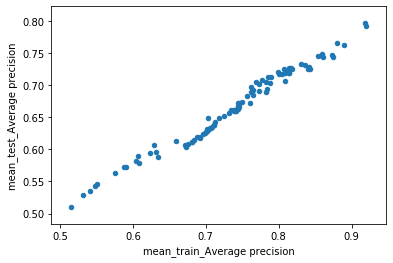

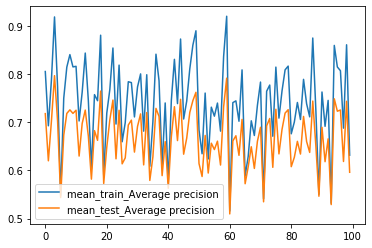

In [86]:
import matplotlib.pyplot as plt
resultsrf.plot.scatter(x='mean_train_Average precision', y='mean_test_Average precision')
plt.show()
resultsrf[['mean_train_Average precision', 'mean_test_Average precision']].plot()

In [87]:
params = {'subsample': 0.5,
 'reg_lambda': 1.0,
 'reg_alpha': 0.5,
 'n_estimators': 100,
 'min_split_loss': 8,
 'min_child_weight': 9,
 'max_depth': 11,
 'max_delta_step': 10,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'colsample_bytree': 1,
 'colsample_bynode': 0.75,
 'colsample_bylevel': 0.75}

xgbrf = xgb.XGBRFClassifier(scale_pos_weight=7, objective='binary:logistic', \
                         eval_metric=['aucpr'], \
                             random_state=random_state, boosting_rounds=50, early_stopping_rounds=10, **params)

#X_train_2folds = pd.concat([fold1[columns], fold2[columns]], axis=0)
# y_train_2folds = pd.concat([fold1['positive_window'], fold2['positive_window']], axis=0)

# eval_set = [(X_val, y_val)]
# evallist = [(X_train_2folds,y_train_2folds), (X_val, y_val)]

xgbrf.fit(X_train, y_train, eval_metric='aucpr', verbose=True)

[08:00:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { boosting_rounds, early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRFClassifier(base_score=0.5, booster='gbtree', boosting_rounds=50,
                colsample_bylevel=0.75, colsample_bynode=0.75,
                colsample_bytree=1, early_stopping_rounds=10,
                eval_metric=['aucpr'], gamma=0.3, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.1, max_delta_step=10, max_depth=11,
                min_child_weight=9, min_split_loss=8, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=0,
                num_parallel_tree=100, objective='binary:logistic',
                random_state=101, reg_alpha=0.5, reg_lambda=1.0,
                scale_pos_weight=7, subsample=0.5, tree_method='exact',
                validate_parameters=1, ...)

In [101]:
y_predrf = xgbrf.predict_proba(X_test)[:,1]
ap = average_precision_score(y_test, y_predrf)
ap


0.3945917968379883

In [89]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_size(16)


[[952  48]
 [151  49]]
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.91      1000
         1.0       0.51      0.24      0.33       200

    accuracy                           0.83      1200
   macro avg       0.68      0.60      0.62      1200
weighted avg       0.80      0.83      0.81      1200

0.5985


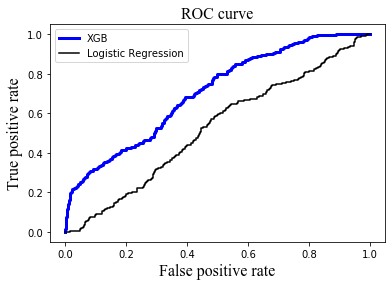

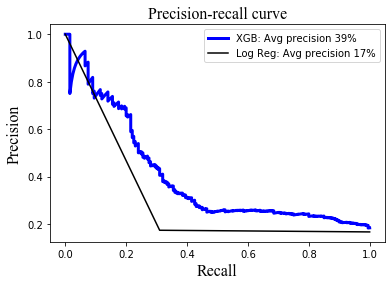

In [109]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scorerf = xgbrf.predict(X_test)

print(confusion_matrix(y_test,y_scorerf))
print(classification_report(y_test,y_scorerf))
print(roc_auc_score(y_test, y_scorerf))

fpr, tpr, auc_th = roc_curve(y_test, y_predrf)
precision, recall, pr_th = precision_recall_curve(y_test, y_predrf)

plt.plot(fpr, tpr,label='XGB',color='b',linewidth=3)
plt.plot(fpr2, tpr2, label='Logistic Regression',color='k')
#plt.plot(fpr3, tpr3)
plt.xlabel('False positive rate',fontsize=16,fontproperties=font)
plt.ylabel('True positive rate',fontproperties=font)
plt.title('ROC curve',fontproperties=font)
plt.legend()
plt.show()
plt.plot(recall, precision,label='XGB: Avg precision 39%',color='b',linewidth=3)
plt.plot(recall2, precision2,label='Log Reg: Avg precision 17%',color='k')
plt.xlabel('Recall',fontproperties=font)
plt.ylabel('Precision',fontproperties=font)
plt.title('Precision-recall curve',fontproperties=font)
plt.legend()
plt.show()

In [73]:
#print(xgbrf.coef_)
print(xgbrf.feature_importances_)

[0.00618466 0.00828622 0.00455959 0.3833227  0.00581767 0.00757533
 0.0048437  0.00633884 0.00642784 0.00677436 0.00834848 0.00750496
 0.00782658 0.00961544 0.00667662 0.00694562 0.00738621 0.00842917
 0.01166349 0.00891904 0.00854231 0.01499266 0.01353355 0.01248297
 0.01019163 0.01046736 0.01093874 0.00940216 0.01173065 0.01015533
 0.01038146 0.0080455  0.00895323 0.01078525 0.03722313 0.
 0.00843443 0.00958362 0.01320022 0.01179993 0.00812981 0.01199019
 0.01916527 0.00831527 0.00915883 0.00908144 0.00887408 0.01313165
 0.01077865 0.00743597 0.00875662 0.02023667 0.04142031 0.01657304
 0.00803405 0.01187351 0.0103827  0.02237137]


In [95]:
np.where(precision>=0.7)

(array([1035, 1036, 1037, 1038, 1040, 1041, 1042, 1043, 1044, 1045, 1046,
        1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057,
        1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068,
        1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079,
        1080, 1081, 1082, 1083, 1084, 1085]),)

In [94]:
for i in np.where(precision>=0.7):
    print(precision[i])
    print(recall[i])

[0.7        0.71428571 0.70833333 0.70212766 0.71111111 0.70454545
 0.72093023 0.73809524 0.73170732 0.725      0.71794872 0.73684211
 0.75675676 0.75       0.74285714 0.73529412 0.72727273 0.75
 0.74193548 0.76666667 0.75862069 0.75       0.74074074 0.73076923
 0.76       0.75       0.7826087  0.81818182 0.80952381 0.8
 0.78947368 0.83333333 0.88235294 0.875      0.86666667 0.92857143
 0.92307692 0.91666667 0.90909091 0.9        0.88888889 0.875
 0.85714286 0.83333333 0.8        0.75       1.         1.
 1.         1.        ]
[0.175 0.175 0.17  0.165 0.16  0.155 0.155 0.155 0.15  0.145 0.14  0.14
 0.14  0.135 0.13  0.125 0.12  0.12  0.115 0.115 0.11  0.105 0.1   0.095
 0.095 0.09  0.09  0.09  0.085 0.08  0.075 0.075 0.075 0.07  0.065 0.065
 0.06  0.055 0.05  0.045 0.04  0.035 0.03  0.025 0.02  0.015 0.015 0.01
 0.005 0.   ]


In [98]:
recall[1048]

0.14

<Figure size 1440x1440 with 0 Axes>

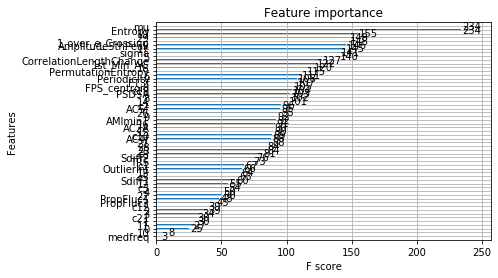

In [74]:
plt.figure(figsize=(20, 20),tight_layout=True)
xgb.plot_importance(xgbrf, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=None, grid=True, show_values=True)


In [110]:
import pickle
# save model to file
pickle.dump(xgbrf, open('xgbrf.pkl', 'wb'))

In [56]:
#np.where(recall>=0.6)
np.where(fpr>0.50)
tpr[352]

0.941

In [36]:
np.where(precision>=0.3)

(array([1172, 1173, 1175, 1176, 1178]),)

In [37]:
recall[1172]

0.01

In [127]:
pr_th[1130]

0.51027197

## Feature importance

In [109]:
my_model2 = xgbrf.fit(X_train, y_train, eval_metric='aucpr', verbose=True)

[23:22:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { boosting_rounds, early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [111]:
mybooster = xgbrf.get_booster()

In [112]:
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


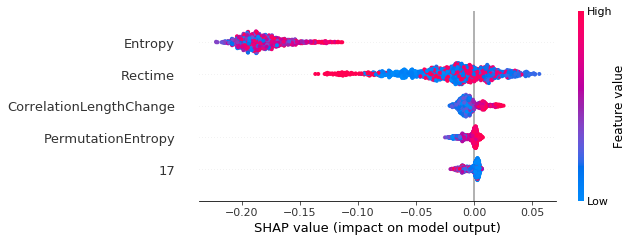

In [113]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(mybooster)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test,check_additivity=False)
shap_values = [shap_values]

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[0], X_test, max_display=5)#,max_display = 20)


In [55]:
[shap_values]

[array([[-3.50822019e-03,  4.83849493e-04, -6.23251021e-01, ...,
         -3.89422849e-03, -2.11118930e-03, -1.74803603e-02],
        [-2.58113723e-03, -2.48108874e-03, -5.88305473e-01, ...,
         -2.49937735e-03,  2.84709851e-03, -3.73348652e-04],
        [-1.81731244e-03, -2.80552485e-04, -5.90397418e-01, ...,
         -3.45597789e-03, -1.32229626e-02, -9.89659876e-03],
        ...,
        [-5.36517822e-04, -5.89314441e-05,  1.79805413e-01, ...,
         -4.02810867e-04, -3.69431451e-03, -9.59148339e-04],
        [-1.14822426e-04, -1.93146669e-04,  1.58806220e-01, ...,
          3.51435563e-04,  7.54625769e-04, -1.12172624e-03],
        [-1.18618831e-04, -5.89959891e-05,  1.56249180e-01, ...,
          7.16748764e-04, -2.79617700e-04, -4.78671544e-04]], dtype=float32)]

In [48]:
len(shap_values)

2

In [51]:
print(shap_values)

[array([[ 2.71026028e-03, -6.75424465e-03,  2.71634466e-01, ...,
         5.61981729e-03,  1.04353760e-03,  1.63285307e-02],
       [ 1.93105169e-03, -1.37258716e-04,  2.56683208e-01, ...,
         8.74700952e-03, -1.19208824e-03,  6.20882983e-04],
       [ 1.52156146e-03, -3.81680320e-03,  2.57030125e-01, ...,
         2.82944798e-03,  4.75993668e-03,  5.29658201e-03],
       ...,
       [ 2.33085902e-03, -1.50367335e-02, -3.99735227e-01, ...,
        -2.18988039e-03,  4.58677198e-03, -3.68265654e-03],
       [-3.89162744e-04, -4.21897586e-03, -3.73956564e-01, ...,
        -1.59637931e-03, -7.25734229e-04, -2.86335087e-03],
       [ 2.71928748e-03, -1.36864915e-02, -3.67259144e-01, ...,
        -1.53709300e-03,  1.64299633e-03,  2.52958524e-04]]), array([[-2.71026028e-03,  6.75424465e-03, -2.71634466e-01, ...,
        -5.61981729e-03, -1.04353760e-03, -1.63285307e-02],
       [-1.93105169e-03,  1.37258716e-04, -2.56683208e-01, ...,
        -8.74700952e-03,  1.19208824e-03, -6.20882983

In [41]:
my_model = RandomForestClassifier(random_state=101).fit(X_train, y_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


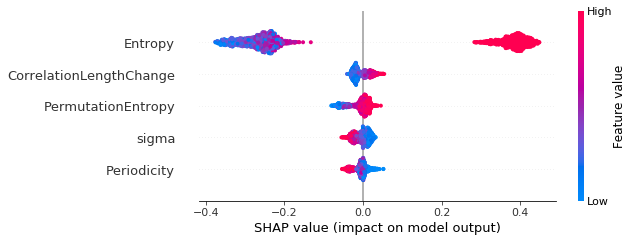

In [42]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test,check_additivity=False)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_test,max_display = 5)

In [37]:
#pred = my_model.fit(X_train, y_train).predict(X_test)
pred = my_model.predict(X_test)
f1 = f1_score(y_test, pred, average='macro')
acc = accuracy_score(y_test, pred)
p1 = precision_score(y_test, pred)
auc = roc_auc_score(y_test, pred)

In [38]:
print('f1-score:', f1)
print('accuracy:', acc)
print('precision:',p1)
print('auc:',auc)
print(confusion_matrix(y_test, pred), '\n')

f1-score: 0.8995050751199563
accuracy: 0.9005
precision: 1.0
auc: 0.9005000000000001
[[1000    0]
 [ 199  801]] 



In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
#Recursive feature elimination
rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='roc_auc')
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=101), scoring='roc_auc')

Optimal number of features: 47


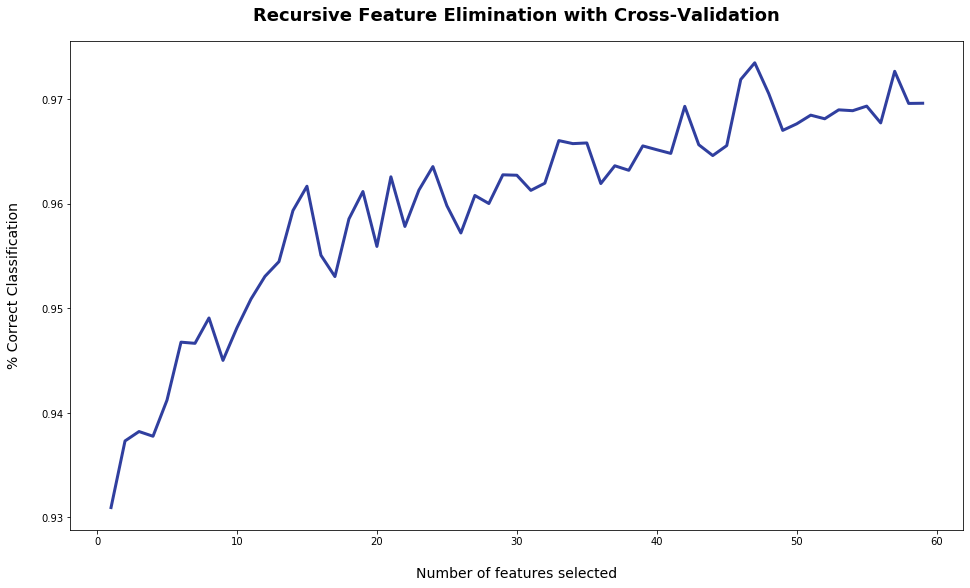

In [142]:
print('Optimal number of features: {}'.format(rfecv.n_features_))
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [143]:
#X_train.columns[57]

In [144]:
print(np.where(rfecv.support_ == True)[0])

[ 0  1  2  4 10 11 12 13 14 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 58]


In [157]:
X_train.columns[56]

'PropFluc2'

In [153]:
X_train.columns

Index(['Rectime', 'mu', 'sigma', 'medfreq', 'Entropy', '0', '1', '2', '3', '4',
       '5', '6', 'FT3f', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', 'PSD5A', '21', '22', '23', 'AC4f', 'AC5f', '26',
       'AC2A', '28', '29', 'Amplitude5thPeak', '31', 'c1', 'c2', 'c3',
       'OutlierInt', 'c5', '1_over_e_Crossing', '1st_Min_AC', 'c8',
       'FPS_centroid', 'c10', 'TRS', 'c12', 'AMImin1', 'Sdiff1', 'Sdiff2',
       'PermutationEntropy', 'CorrelationLengthChange', 'c18', 'PropFluc1',
       'PropFluc2', 'c21', 'Periodicity'],
      dtype='object')

In [183]:
[['Rectime', 'mu', 'sigma','Entropy',
       '5', '6', 'FT3f', '8', '9', '13', '14', '15', '16',
       '17', '18', '19', 'PSD5A', '21', '22', '23', 'AC4f', 'AC5f', '26',
       'AC2A', '28', '29', 'Amplitude5thPeak', 'c1', 'c2', 'c3',
       'OutlierInt', 'c5', '1_over_e_Crossing', '1st_Min_AC', 'c8',
       'FPS_centroid', 'c10', 'TRS', 'c12', 'AMImin1', 'Sdiff1', 'Sdiff2',
       'PermutationEntropy', 'CorrelationLengthChange', 'c18', 'PropFluc1',
       'PropFluc2','Periodicity']]

[['Rectime',
  'mu',
  'sigma',
  'Entropy',
  '5',
  '6',
  'FT3f',
  '8',
  '9',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  'PSD5A',
  '21',
  '22',
  '23',
  'AC4f',
  'AC5f',
  '26',
  'AC2A',
  '28',
  '29',
  'Amplitude5thPeak',
  'c1',
  'c2',
  'c3',
  'OutlierInt',
  'c5',
  '1_over_e_Crossing',
  '1st_Min_AC',
  'c8',
  'FPS_centroid',
  'c10',
  'TRS',
  'c12',
  'AMImin1',
  'Sdiff1',
  'Sdiff2',
  'PermutationEntropy',
  'CorrelationLengthChange',
  'c18',
  'PropFluc1',
  'PropFluc2',
  'Periodicity']]

## RF Tuning-->all params

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.ensemble import RandomForestClassifier

random_state=101

search_space = [
  {'n_estimators': [50, 100, 200],
   'criterion': ['gini', 'entropy'],
   'max_depth': range(3,13),
   'min_samples_split': [2, 4, 8, 16],
   'min_samples_leaf': range(1,6),
   'max_features': ['sqrt', 'log2', 0.5, None],
   'max_leaf_nodes':[None, 10, 50, 100],
   'min_impurity_decrease': [0, 0.01, 0.05, 0.1],
   'bootstrap': [True, False],
   'ccp_alpha': [0, 0.01, 0.05, 0.1],
   'max_samples': [None, 0.5, 0.8]
  }
]

rf = RandomForestClassifier(n_jobs = -1, random_state=random_state, class_weight = 'balanced_subsample')

# AUC and average precision as score
scoring = {'AUC':'roc_auc', 'Average precision':make_scorer(average_precision_score)}
# Define grid search
grid = RandomizedSearchCV(
                          rf,
                          search_space,
                          cv=3,
                          scoring=scoring,
                          refit='Average precision',
                          n_iter=250,
                          verbose=1,
                          n_jobs=-1,
                          return_train_score=True
)
# Fit grid search
model = grid.fit(X_train, y_train)

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 16.9min finished


In [38]:
resultsrf = pd.DataFrame({'mean_test_AUC':grid.cv_results_['mean_test_AUC'], \
                        'mean_train_AUC':grid.cv_results_['mean_train_AUC'],\
                        'mean_test_Average precision':grid.cv_results_['mean_test_Average precision'],\
                        'mean_train_Average precision':grid.cv_results_['mean_train_Average precision']})
resultsrf.sort_values(by='mean_test_Average precision', ascending=False).head(30)

,mean_test_AUC,mean_train_AUC,mean_test_Average precision,mean_train_Average precision
125,0.933665,0.933654,0.933665,0.933653
165,0.945027,0.952718,0.933665,0.933653
150,0.933665,0.933653,0.933665,0.933653
151,0.931441,0.935284,0.933665,0.933653
152,0.933665,0.933653,0.933665,0.933653
153,0.933665,0.933653,0.933665,0.933653
154,0.933665,0.933653,0.933665,0.933653
155,0.931052,0.945112,0.933665,0.933653
156,0.937295,0.940838,0.933665,0.933653
157,0.933665,0.933653,0.933665,0.933653


In [39]:
grid.best_params_

{'n_estimators': 50,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'min_impurity_decrease': 0.05,
 'max_samples': 0.5,
 'max_leaf_nodes': 10,
 'max_features': 0.5,
 'max_depth': 3,
 'criterion': 'entropy',
 'ccp_alpha': 0.01,
 'bootstrap': True}

[[1000    0]
 [ 200    0]]
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      1000
         1.0       0.00      0.00      0.00       200

    accuracy                           0.83      1200
   macro avg       0.42      0.50      0.45      1200
weighted avg       0.69      0.83      0.76      1200



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


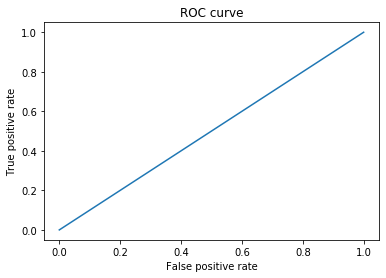

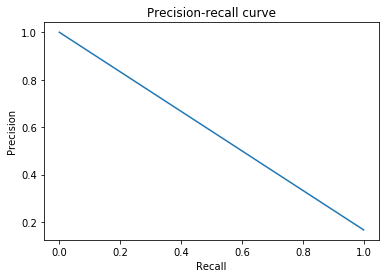

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_pred = grid.best_estimator_.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

fpr, tpr, auc_th = roc_curve(y_test, y_pred)
precision, recall, pr_th = precision_recall_curve(y_test, y_pred)

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.show()

In [42]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 4)]
n_estimators = [1000, 2000]
max_features = [3, 4, 5, 10, 30]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples reqiuired at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {
               'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split}
print(random_grid)

{'n_estimators': [1000, 2000], 'max_features': [3, 4, 5, 10, 30], 'min_samples_split': [2, 10]}


In [43]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, \
                               cv = StratifiedKFold(5), verbose=2, random_state=101, scoring = 'roc_auc', n_jobs = -1)
# Fit the random search model


# Fit the random search model
#model = rf_random.fit(X_train, y_train)
#model = rf_random.fit(train_pca, y_train)
#pred = rf_random.fit(X_train, y_train).predict(X_test)
#pred = model.fit(X_train, y_train).predict(X_test)
pred = rf_random.fit(X_train, y_train).predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.5min finished


In [99]:
#pred = model.fit(X_train, y_train).predict(X_test)
f1 = f1_score(y_test, pred, average='macro')
acc = accuracy_score(y_test, pred)
p1 = precision_score(y_test, pred)
auc = roc_auc_score(y_test, pred)
        
print('RF')
print('f1-score:', f1)
print('accuracy:', acc)
print('precision:',p1)
print('auc:',auc)
print(confusion_matrix(y_test, pred), '\n')

RF
f1-score: 0.8980205897439005
accuracy: 0.899
precision: 0.996268656716418
auc: 0.899
[[997   3]
 [199 801]] 



In [157]:
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

(60.5, -0.5)

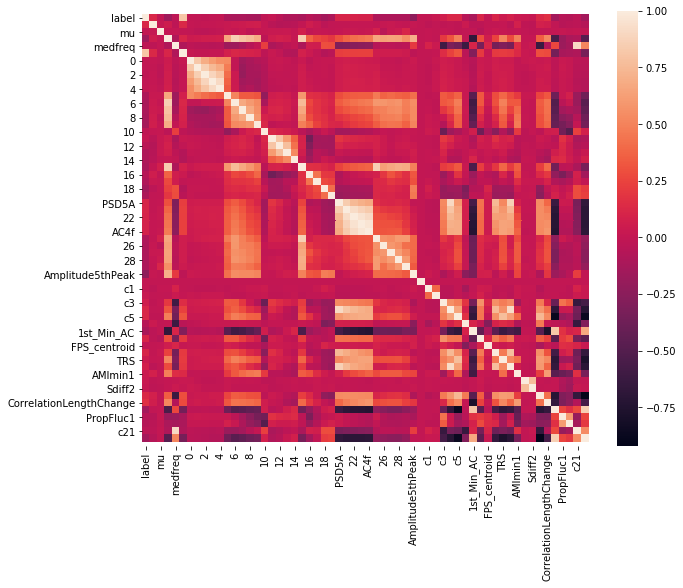

In [36]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(d_train.corr())
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

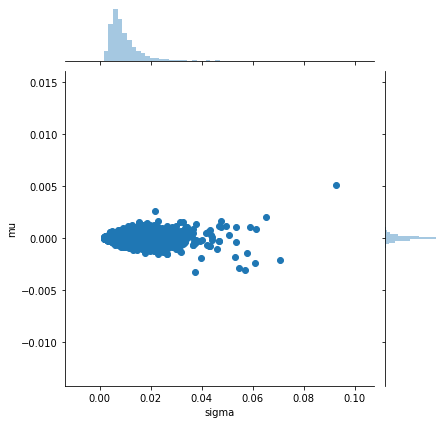

In [80]:
sns.jointplot(x='sigma',y='mu',data=d_train,kind='scatter')